# Neural Network Approach for Document Categorization

use bi-directional LSTM with self attention

In [ ]:
import re 
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Gensim
import gensim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

[nltk_data] Downloading package stopwords to /home/sxia1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## given a corpus clean each text in the collection

In [3]:
#helper function for lemmatization
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n' #if not belong to any, default is noun, inclunding N

def lemmatize_with_pos(abstract_toekenized):
    abstract_tagged = nltk.pos_tag(abstract_toekenized)
    tags = list(map(lambda token: get_wordnet_pos(token[1]),abstract_tagged))
    abstract_lemmatized = list(map(lemmatizer.lemmatize,abstract_toekenized,tags))
    return abstract_lemmatized


#import nltk lemmatizer
lemmatizer = WordNetLemmatizer()

def prepare_token(text_tokenized_list):
    # remove stopwords and puntuation, 
    text_stopwords_removed = list(map(lambda abstract: list(filter(lambda word: word not in stop_words, abstract)),text_tokenized_list))
    # lemmatize
    abstract_lemmatized = list(map(lemmatize_with_pos,text_stopwords_removed))
    return abstract_lemmatized

def tokenize_prepare(df):
    # remove puncutations and number, then tokenize each text
    text_tokenized = list(map(lambda abstract_i:nltk.word_tokenize(re.sub(r'[^A-Za-z\s]','',abstract_i.lower())), df.Abstract))
    len(text_tokenized)
    df['n_words']=list(map(lambda x:len(x),text_tokenized))
    #come back to adjust the threshold value: (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold
    # bigram_freeze = bigram.freeze()
    abstract_lemmatized = prepare_token(text_tokenized)
    df['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))
    # plot data
    fig,axs = plt.subplots(1,4,figsize=(25,5))
    categories = df.Domain.value_counts().index
    counts = df.Domain.value_counts().values
    axs[0].bar(categories, counts, width=0.5)
    axs[0].set_title("Domain Frquency")
    categories = df.area.value_counts().index
    counts = df.area.value_counts().values
    axs[1].bar(categories, counts, width=0.5)
    axs[1].set_title("Area Frquency")
    axs[2].hist(df.n_words)
    axs[2].set_title("abstract word count")
    axs[3].hist(df.n_words_removed,bins=30)
    axs[3].set_title("abstract without stop words word count")

    plt.show()
    return abstract_lemmatized,df



46985
['CS ' 'Medical ' 'Civil ' 'ECE ' 'biochemistry ' 'MAE ' 'Psychology  ']


/tmp/ipykernel_27035/3351567712.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['Domain_No'] = df_paper.Domain.map(topic2num)
/tmp/ipykernel_27035/4293104228.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_words']=list(map(lambda x:len(x),text_tokenized))
/tmp/ipykernel_27035/4293104228.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

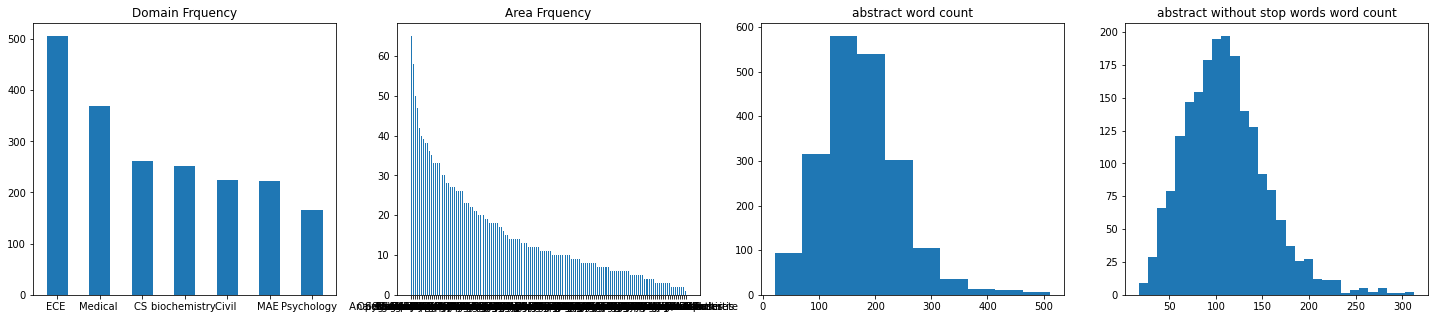

In [10]:
stop_words = stopwords.words('english')
# read-in pre-labled research apper abstracts
df_paper_raw = pd.read_excel("data/WebOfScienceData.xlsx",sheet_name="abstracts")
print(len(df_paper_raw))
df_paper = df_paper_raw.head(2000) #use first 2000
print(df_paper.Domain.unique())
topic2num = {'CS ': 0, 'Medical ': 1, 'Civil ': 2, 'ECE ': 3, 'biochemistry ': 4, 'MAE ': 5, 'Psychology  ': 6}
df_paper['Domain_No'] = df_paper.Domain.map(topic2num)

abstract_lemmatized, df= tokenize_prepare(df_paper)



['use', 'model', 'system', 'result', 'study', 'method', 'propose', 'show', 'control', 'c', 'present', 'base', 'design', 'analysis', 'high', 'cell', 'data', 'also', 'patient', 'effect', 'increase', 'two', 'different', 'elsevier', 'time', 'process', 'develop', 'right', 'provide', 'new', 'paper', 'include', 'reserve', 'power', 'approach', 'compare', 'performance', 'test', 'algorithm', 'level', 'low', 'measure', 'structure', 'well', 'energy', 'condition', 'find', 'function', 'one', 'may', 'parameter', 'application', 'simulation', 'current', 'signal']


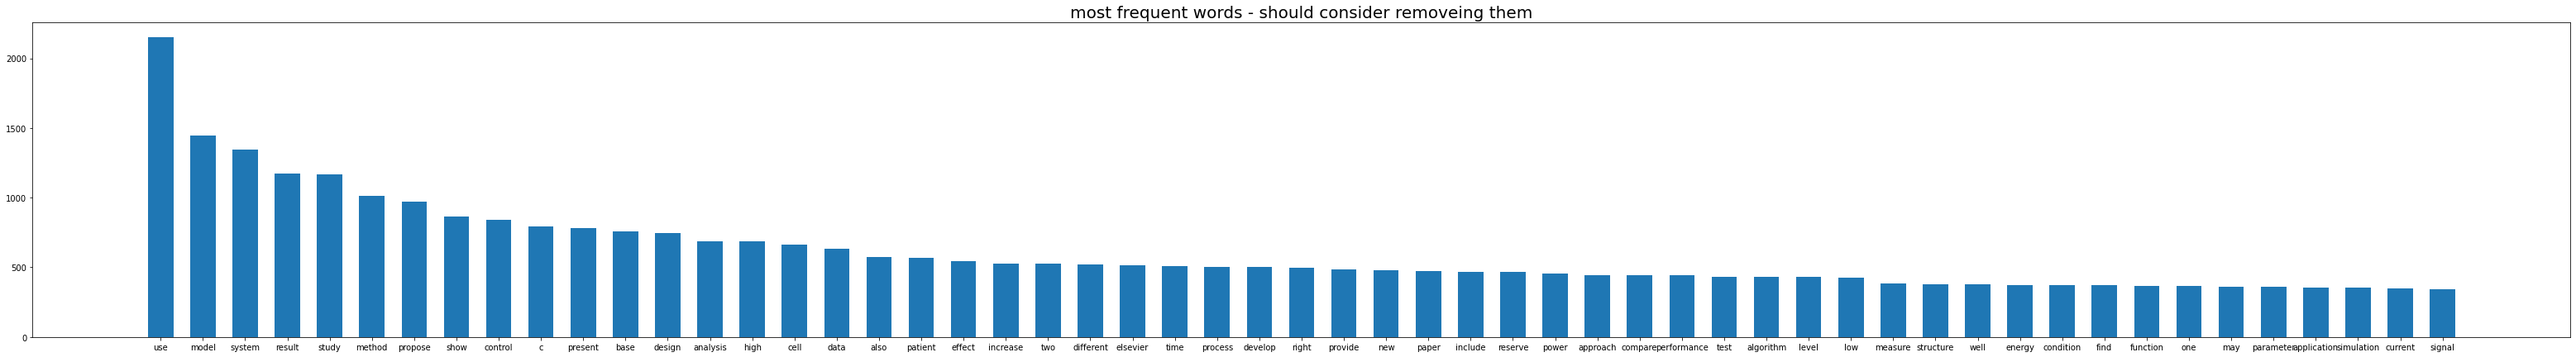

['low', 'measure', 'structure', 'well', 'condition', 'energy', 'find', 'function', 'one', 'may', 'parameter', 'application', 'simulation', 'current', 'signal', 'obtain', 'group', 'frequency', 'change', 'dynamic']


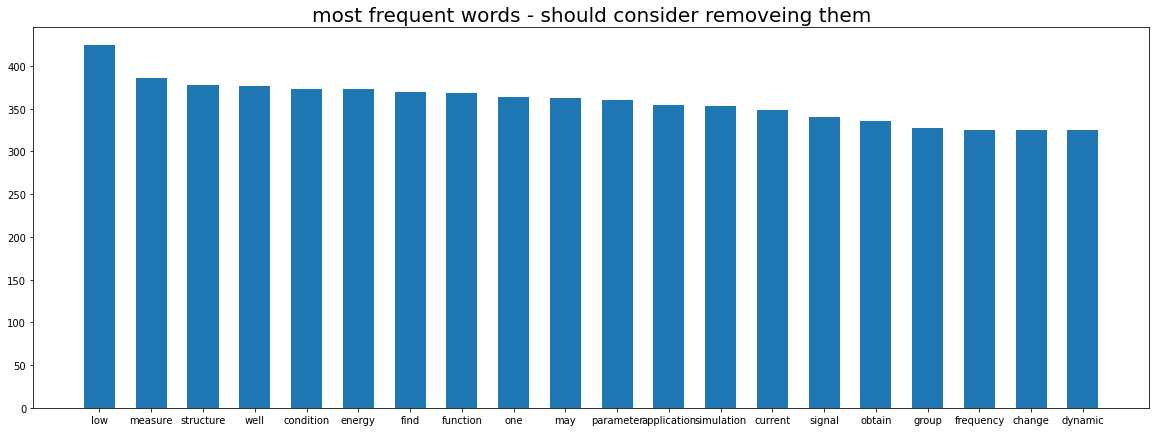

/tmp/ipykernel_27035/3453406941.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))


Text(200, 150, 'median length: 92')

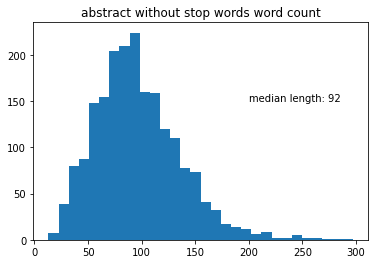

In [11]:
# remove popular words??
def check_frequent_words(corpus,top_n):
    all_corpus_together=np.concatenate(corpus)
    (word, counts) = np.unique(all_corpus_together, return_counts=True)
    frequencies = np.asarray((word, counts)).T
    count_df = pd.DataFrame(data=frequencies,columns = ['word','freq'])
    count_df.freq = count_df.freq.astype(int)
    count_df.sort_values(by=['freq'],axis=0,ascending=False,ignore_index=True,inplace=True)
    print(list(count_df.head(top_n).word))
    plt.figure(figsize=(top_n,7))
    plt.bar(count_df[:top_n].word,height=count_df[:top_n].freq,width=0.6,align='center')
    plt.title("most frequent words - should consider removeing them",fontsize=20)
    plt.show()
    return count_df

count_df =check_frequent_words(abstract_lemmatized,55)

# remove top 50 most frequent words
top_n = list(count_df[:40].word)
abstract_lemmatized_cleaned = list(map(lambda abstract: list(filter(lambda word: word not in top_n, abstract)),abstract_lemmatized))
check_frequent_words(abstract_lemmatized_cleaned,top_n=20)
df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))
median_count = np.median(df_paper.n_words_lemmatize_clean)
plt.hist(df_paper.n_words_lemmatize_clean,bins=30)
plt.title("abstract without stop words word count")
plt.text(200,150,"median length: %d"%median_count,fontsize=10)

In [6]:
list(map(lambda x:len(x),abstract_lemmatized_cleaned))

[86, 126, 67, 76, 113, 107, 80, 78, 122, 111]

## Building our Nerual Network
1. define and train word2vec from Gensim
2. apply word2vec on our documents 
3. input to the nerual network: vectorized document using word2vec
4. output: distribution of topics (a vector with length = # topics)

5. cross entropy function:

In [5]:
import gensim.downloader
from gensim.models import Word2Vec

glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

In [6]:
print(np.shape(glove_vectors['medicine']))
print(np.shape(glove_vectors['water']))
#word vector/input dim = 100
global embedding_dim
embedding_dim = np.shape(glove_vectors['water'])[0]

(100,)
(100,)


In [55]:
# apply word2vec and vectorize corpus

text_i = abstract_lemmatized_cleaned[0]
def embed_w_word2vec(word):
    try:
        return glove_vectors[word]
    except:
        return np.zeros(embedding_dim) #unseen word -> zeros 

text_embedded = np.array(list(map(embed_w_word2vec, text_i)))
print("# unseen words:",np.sum(np.sum(text_embedded,axis=1)==0))

n_document = 100
n_topics = 7
corpus_embedded = list(map(lambda text_i: np.asarray(list(map(embed_w_word2vec, text_i))),abstract_lemmatized_cleaned[:n_document]))
print(np.shape(corpus_embedded[1]))
# one-hot encoding for topic
topic_vec = np.zeros((n_document,n_topics))
for i in range(n_document):
    topic_vec[i][df_paper.Domain_No[i]]= 1

# split into training and testing data
X = corpus_embedded
Y = df_paper.Domain_No[:n_document]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.25,)

# unseen words: 8
(170, 100)


In [7]:
class myBi_LSTM():
    def __init__(self, embedding_dim, hidden_dim,learning_rate=1e-2, device='cpu'):


        self.loss_func = nn.CrossEntropyLoss() # loss function

        """Initialize."""
        self.device = device
        self.learning_rate = learning_rate

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim #how to choose hidden_dim? hidden_dim = # of topics
        self.net = nn.Sequential(
            nn.LSTM(embedding_dim, self.hidden_dim,bidirectional=True,batch_first=True), #batch_first = True means using all documents to train once
            nn.Softmax() #just scaling, input dim = output dim
        )

        self.loss_func = nn.CrossEntropyLoss()

        if self.device == 'cuda':
            self.net.cuda() #net is for nueral network

        #constructing optimizers, adam algorithm
        self.optimizer = torch.optim.Adam(
            self.net.parameters(), 
            lr=self.learning_rate,
        )


        super().__init__()  

    def predict(self, X_t):
        """Predict."""
        return self.net(X_t) #model(x) gives the predicted value

    def update_network(self, y_hat, Y_t):
        """Update weights."""
        self.optimizer.zero_grad() #restart losses from last step, so error won't accumulate
        loss = self.loss_func(y_hat, Y_t) #compute loss by calling loss_func method
        loss.backward()
        self.optimizer.step()
        self.training_loss.append(loss.item())

    def calculate_accuracy(self, y_hat_class, Y):
        """Calculate accuracy."""
        return np.sum(Y.reshape(-1, 1) == y_hat_class) / len(Y)

    def train(self, X, Y, n_iters=1000):
        """Train network."""
        print("here")
        self.training_loss = []
        self.training_accuracy = []
        print(np.shape(X))
        print(np.shape(Y))

        X_t = torch.FloatTensor(X).to(device=self.device) 
        #this is just writing our training np narray into tensor datatype. Tensor can run on both CPU and CPU(cuda)
        Y = Y.reshape(-1, 1)
        Y_t = torch.FloatTensor(Y).to(device=self.device)

        for _ in range(n_iters):
            y_hat = self.predict(X_t)
            self.update_network(y_hat, Y_t)
            y_hat_class = np.argmax(y_hat) # max probabilty -> text category
            accuracy = self.calculate_accuracy(y_hat_class, Y)
            self.training_accuracy.append(accuracy)

    def plot_training_progress(self):
        """Plot training progress."""
        fig, ax = plt.subplots(2, 1, figsize=(12, 8))
        ax[0].plot(self.training_loss)
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Training Loss')

        ax[1].plot(self.training_accuracy)
        ax[1].set_ylabel('Classification Accuracy')
        ax[1].set_title('Training Accuracy')

        plt.tight_layout()
        plt.show()

In [59]:
x = np.array([corpus_embedded[0],corpus_embedded[2]])
np.shape(x)


/tmp/ipykernel_27035/2889615265.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array([corpus_embedded[0],corpus_embedded[2]])


(2,)

In [64]:
x = np.random.rand(6,3,2)
x_t = torch.FloatTensor(X_train[0]).to(device="cpu")

In [62]:
type(x[0])

numpy.ndarray

In [91]:
net = myBi_LSTM(embedding_dim=embedding_dim,hidden_dim=n_topics)
net.train(X_train,Y_train)

here
(75,)
(75,)


/home/sxia1/.nlp_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


ValueError: expected sequence of length 66 at dim 1 (got 164)